In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from nsidc_processor import GeotiffProcessor
from ice_modeler import IceModeler

Using TensorFlow backend.


In [3]:
geotiff_index = pd.read_csv('daily_northern_geotiff_index.csv')
geotiff_index.date = pd.to_datetime(geotiff_index.date)
geotiff_index = geotiff_index.set_index('date')

In [4]:
geotiff_concentration = geotiff_index.loc[geotiff_index.image_type == 'concentration']

In [5]:
conc_last_ten = geotiff_concentration.loc['2009-01-01':'2018-12-31',:]

In [6]:
conc_processor = GeotiffProcessor('raw_images/', image_index=conc_last_ten)

In [7]:
conc_last_ten

,Unnamed: 0,file_name,hemisphere,image_type
date,,,,
2009-01-01,N_20090101_concentration_v3.0,daily/geotiff/2009/N_20090101_concentration_v3...,north,concentration
2009-01-02,N_20090102_concentration_v3.0,daily/geotiff/2009/N_20090102_concentration_v3...,north,concentration
2009-01-03,N_20090103_concentration_v3.0,daily/geotiff/2009/N_20090103_concentration_v3...,north,concentration
2009-01-04,N_20090104_concentration_v3.0,daily/geotiff/2009/N_20090104_concentration_v3...,north,concentration
2009-01-05,N_20090105_concentration_v3.0,daily/geotiff/2009/N_20090105_concentration_v3...,north,concentration
...,...,...,...,...
2018-12-27,N_20181227_concentration_v3.0,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,N_20181228_concentration_v3.0,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,N_20181229_concentration_v3.0,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration


In [8]:
conc_processor.load_default_colormaps(
    extent='default_extent_colormap.pkl',
    concentration='default_concentration_colormap.pkl')
# conc_last_ten = conc_processor.impute_missing_index_dates(set_this_index=True)

In [9]:
ice_modeler = IceModeler()

In [10]:
conc_images, years = conc_processor.process_images_channels_first_yearly_sample()

In [11]:
norm_images = ice_modeler.scale_to_normal(conc_images, image_type='concentration')

In [12]:
x_train = norm_images[:7]
y_train = norm_images[1:8]
x_test = norm_images[7:10]
y_test = norm_images[8:]

In [144]:
scaled_tanh = ice_modeler.make_hard_tanh(1.2)

In [172]:
ice_modeler.reset_model()
ice_modeler.add_n_td_conv2d(1, filters=8, kernel_size=(6,6), padding='same')
ice_modeler.add_td_avg_pool(pool_size=(2,2), strides=2, padding='valid')
ice_modeler.add_td_flatten()
ice_modeler.add_n_tcn(1, nb_filters=10, kernel_size=20, nb_stacks=2)
ice_modeler.add_n_td_dense(1, ice_modeler.image_size)
ice_modeler.add_td_im_reshape()

In [173]:
ice_modeler.compile(loss='mean_squared_error', optimizer='adam')

In [179]:
ice_modeler.fit(x_train, y_train, epochs=2)

Epoch 1/2
7/7 [==============================] - 294s 42s/step - loss: 0.0114
Epoch 2/2
7/7 [==============================] - 291s 42s/step - loss: 0.0076


In [180]:
predictions = ice_modeler.predict(x_test)

In [181]:
predictions.shape

(3, 365, 1, 448, 304)

In [182]:
predictions_images = ice_modeler.scale_from_normal(predictions, image_type='concentration')

[[[  58   94   47 ... 2540 2540 2540]
  [   0    9    0 ... 2540 2540 2540]
  [ 134   20    0 ... 2540 2540 2540]
  ...
  [2540 2540 2540 ...   67    0  150]
  [2540 2540 2540 ...   49    0    0]
  [2540 2540 2540 ...    0   27    0]]]
[[[  58.   94.   47. ... 2540. 2540. 2540.]
  [   0.    9.    0. ... 2540. 2540. 2540.]
  [ 134.   20.    0. ... 2540. 2540. 2540.]
  ...
  [2540. 2540. 2540. ...   67.    0.  150.]
  [2540. 2540. 2540. ...   49.    0.    0.]
  [2540. 2540. 2540. ...    0.   27.    0.]]]
[[[   0    0    0 ... 2540 2540 2540]
  [   0    0    0 ... 2540 2540 2540]
  [   0    0    0 ... 2540 2540 2540]
  ...
  [2540 2540 2540 ...    0    0    0]
  [2540 2540 2540 ...    0    0    0]
  [2540 2540 2540 ...    0    0    0]]]
[[[   0.    0.    0. ... 2540. 2540. 2540.]
  [   0.    0.    0. ... 2540. 2540. 2540.]
  [   0.    0.    0. ... 2540. 2540. 2540.]
  ...
  [2540. 2540. 2540. ...    0.    0.    0.]
  [2540. 2540. 2540. ...    0.    0.    0.]
  [2540. 2540. 2540. ...    0.

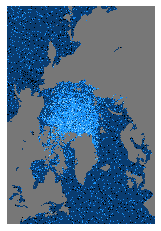

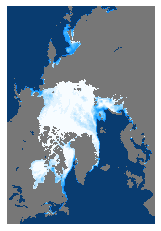

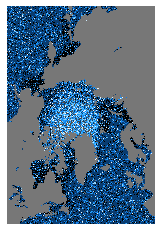

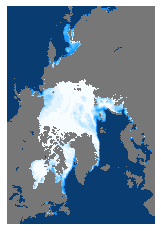

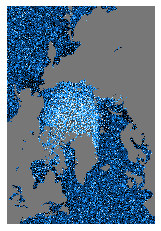

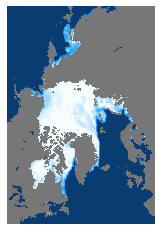

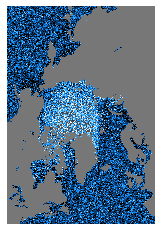

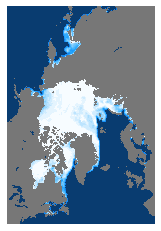

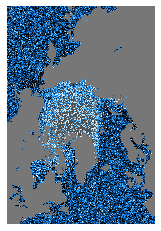

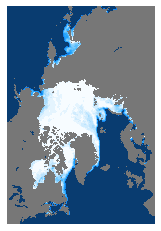

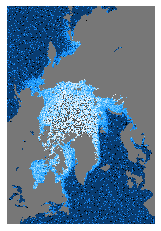

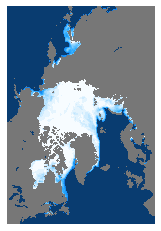

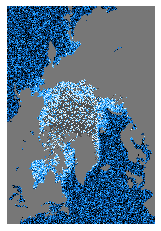

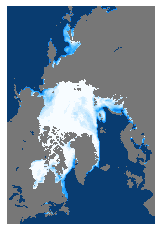

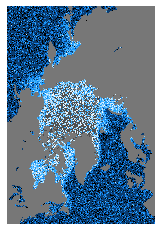

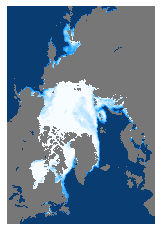

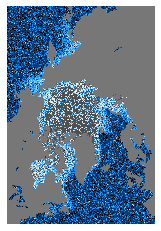

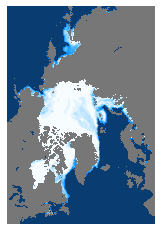

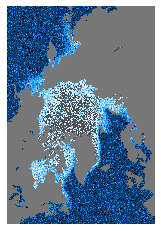

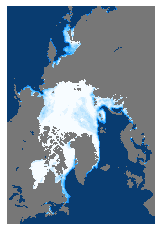

In [183]:
for i in range(10):
    frame = predictions_images[1, i, :, :]
    actual = ice_modeler.scale_from_normal(y_test[0, i, :, :], image_type='concentration')
    conc_processor.make_colored_prediction_image(frame, image_type='concentration')
    conc_processor.make_colored_prediction_image(actual, image_type='concentration')
